In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [107]:
from google.colab import drive
drive.mount('/content/drive')

hotel = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_train.csv')
hotel_t = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_test.csv')
hotel_orig = hotel_t.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
hotel = hotel[hotel['adr']>0]
total_filas = hotel.shape[0]
hotel.shape

(61028, 32)

In [109]:
hotel['children'].fillna(0,inplace = True)
hotel['country'].fillna('PRT',inplace = True)
hotel['agent'].fillna(0,inplace = True)
hotel['company'].fillna(0,inplace = True)


hotel_t['children'].fillna(0,inplace = True)
hotel_t['country'].fillna('PRT',inplace = True)
hotel_t['agent'].fillna(0,inplace = True)
hotel_t['company'].fillna(0,inplace = True)


In [110]:
minmax = MinMaxScaler()
def do_feature_engineering(df):
    df['lead_time'] = minmax.fit_transform(df[['lead_time']])
    df['adults'] = minmax.fit_transform(df[['adults']])
    df['adr'] = minmax.fit_transform(df[['adr']])
    # df['stays_in_week_nights'] = minmax.fit_transform(df[['stays_in_week_nights']])
    # df['stays_in_weekend_nights'] = minmax.fit_transform(df[['stays_in_weekend_nights']])
    df.loc[df['country'] != 'PRT', 'is_foreign_client'] = 1
    df.loc[df['country'] == 'PRT', 'is_foreign_client'] = 0
    df.loc[df['babies'] > 0, 'has_babies'] = 1
    df.loc[df['babies'] == 0, 'has_babies'] = 0
    df.loc[df['children'] > 0, 'has_children'] = 1
    df.loc[df['children'] == 0, 'has_children'] = 0
    df.loc[df['agent'] > 0, 'sold_by_agent'] = 1
    df.loc[df['agent'] == 0, 'sold_by_agent'] = 0
    df.loc[df['company'] > 0, 'sold_by_company'] = 1
    df.loc[df['company'] == 0, 'sold_by_company'] = 0
    df.loc[df['previous_bookings_not_canceled'] > 0, 'has_previous_bookings_not_canceled'] = 1
    df.loc[df['previous_bookings_not_canceled'] == 0, 'has_previous_bookings_not_canceled'] = 0
    df.loc[df['booking_changes'] > 0, 'has_booking_changes'] = 1
    df.loc[df['booking_changes'] == 0, 'has_booking_changes'] = 0
    df.loc[df['days_in_waiting_list'] > 0, 'days_in_waiting_list_over_one'] = 1
    df.loc[df['days_in_waiting_list'] == 0, 'days_in_waiting_list_over_one'] = 0
    df.loc[df['total_of_special_requests'] > 0, 'has_special_requests'] = 1
    df.loc[df['total_of_special_requests'] == 0, 'has_special_requests'] = 0
    df.loc[df['required_car_parking_spaces'] > 0, 'has_required_car_parking_spaces'] = 1
    df.loc[df['required_car_parking_spaces'] == 0, 'has_required_car_parking_spaces'] = 0
    df.loc[df['previous_cancellations'] > 0, 'has_previous_cancellations'] = 1
    df.loc[df['previous_cancellations'] == 0, 'has_previous_cancellations'] = 0
    df.loc[df['reserved_room_type'] == df['assigned_room_type'], 'requested_room_matches_assigned'] = 1
    df.loc[df['reserved_room_type'] != df['assigned_room_type'], 'requested_room_matches_assigned'] = 0

do_feature_engineering(hotel)
do_feature_engineering(hotel_t)

In [111]:
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date', 'country', 'company', 'agent','babies', 'children','total_of_special_requests','previous_cancellations', 'reserved_room_type', 'assigned_room_type', 'previous_bookings_not_canceled','booking_changes','days_in_waiting_list' ]
hotel.drop(columnas_eliminar, axis='columns', inplace=True)
hotel_t.drop(columnas_eliminar, axis='columns', inplace=True)
hotel.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'deposit_type',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'is_canceled',
 'is_foreign_client',
 'has_babies',
 'has_children',
 'sold_by_agent',
 'sold_by_company',
 'has_previous_bookings_not_canceled',
 'has_booking_changes',
 'days_in_waiting_list_over_one',
 'has_special_requests',
 'has_required_car_parking_spaces',
 'has_previous_cancellations',
 'requested_room_matches_assigned']

In [112]:
def higher_probability(a,b):
    if a == b:
        return 0
    else:
        return 1

hotel['hotel'] = hotel['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel['market_segment'] = hotel['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel['distribution_channel'] = hotel['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
''' hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None) '''
''' hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None) '''
''' hotel['agent'] = hotel['agent'].apply(higher_probability,b=0) '''
''' hotel['company'] = hotel['company'].apply(higher_probability,b=0) '''


hotel_t['hotel'] = hotel_t['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel_t['arrival_date_month'] = hotel_t['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel_t['market_segment'] = hotel_t['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel_t['distribution_channel'] = hotel_t['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
''' hotel_t['reserved_room_type'] = hotel_t['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None) '''
''' hotel_t['assigned_room_type'] = hotel_t['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None) '''
''' hotel_t['agent'] = hotel_t['agent'].apply(higher_probability,b=0) '''
''' hotel_t['company'] = hotel_t['company'].apply(higher_probability,b=0) '''

hotel.head()

,hotel,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,market_segment,distribution_channel,is_repeated_guest,deposit_type,...,has_children,sold_by_agent,sold_by_company,has_previous_bookings_not_canceled,has_booking_changes,days_in_waiting_list_over_one,has_special_requests,has_required_car_parking_spaces,has_previous_cancellations,requested_room_matches_assigned
0,1,0.077901,9,1,2,0.25,1,1,0,No Deposit,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0,0.006359,10,0,1,0.50,2,2,0,No Deposit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1,0.039746,10,0,1,0.50,1,1,0,No Deposit,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0.041335,12,2,5,0.50,2,1,0,Non Refund,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0.165342,3,2,5,0.50,3,1,0,No Deposit,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [113]:
#Dummies para deposit_type
hotel = pd.get_dummies(hotel, columns=['deposit_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['deposit_type'], drop_first=True)

#Dummies para customer_type
hotel = pd.get_dummies(hotel, columns=['customer_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['customer_type'], drop_first=True)

In [114]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [115]:
target='is_canceled'
hotel_x=hotel.drop([target], axis='columns', inplace=False)
hotel_y = hotel[target].copy()

In [116]:
x_train, x_test, y_train, y_test = train_test_split(hotel_x, 
                                                    hotel_y, 
                                                    test_size=0.20,  
                                                    random_state=5, )

In [117]:
stand_scaler = StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)


In [118]:
d_in=len(x_train.columns)

modelo_hotel_1 = keras.Sequential([
    keras.layers.Dense(12, input_shape=(d_in, ),activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
    keras.layers.Dense(1, )])

modelo_hotel_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 12)                348       
                                                                 
 dense_59 (Dense)            (None, 8)                 104       
                                                                 
 dense_60 (Dense)            (None, 1)                 9         
                                                                 
 dense_61 (Dense)            (None, 1)                 2         
                                                                 
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [119]:
modelo_hotel_1.compile(
  loss='mse',
  optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08),
  metrics=['mse','acc'], 
)

cant_epochs_titanic=100
modelo_titanic1_historia = modelo_hotel_1.fit(x_train_norm,y_train,epochs=cant_epochs_titanic,batch_size=60,verbose=False)

382/382 [==============================] - 0s 899us/step
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      6499
           1       0.80      0.86      0.83      5707

    accuracy                           0.83     12206
   macro avg       0.83      0.83      0.83     12206
weighted avg       0.84      0.83      0.83     12206



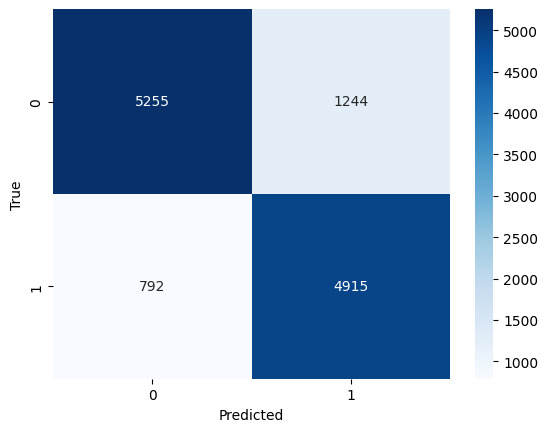

In [120]:
y_predic_ej1 = modelo_hotel_1.predict(x_test_norm)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.5,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

metricas(ds_validacion.y_pred, ds_validacion.y_real)

In [121]:
d_in=len(x_train.columns)

modelo_hotel_2 = keras.Sequential([
    keras.layers.Dense(20, input_shape=(d_in, ),activation='relu'),
    keras.layers.Dense(15, activation='tanh'),
    keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(1, )])

modelo_hotel_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 20)                580       
                                                                 
 dense_63 (Dense)            (None, 15)                315       
                                                                 
 dense_64 (Dense)            (None, 10)                160       
                                                                 
 dense_65 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,066
Trainable params: 1,066
Non-trainable params: 0
_________________________________________________________________


In [122]:
modelo_hotel_2.compile(
    loss='mse', 
    optimizer='nadam',
    metrics=['mse','acc']) 

cant_epochs_titanic=100
modelo_titanic1_historia = modelo_hotel_2.fit(x_train_norm,y_train,epochs=cant_epochs_titanic,batch_size=60,verbose=False)


382/382 [==============================] - 0s 831us/step
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      6413
           1       0.81      0.86      0.83      5793

    accuracy                           0.84     12206
   macro avg       0.84      0.84      0.84     12206
weighted avg       0.84      0.84      0.84     12206



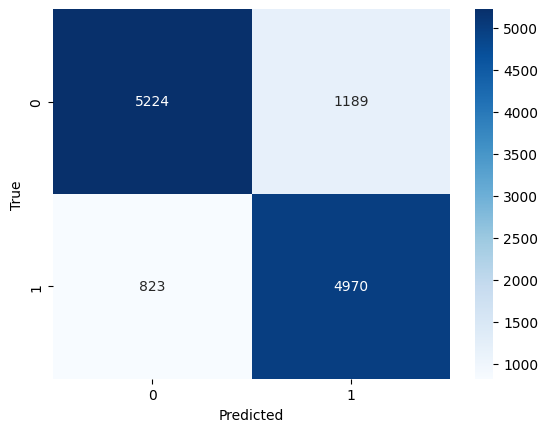

In [123]:
y_predic_ej2 = modelo_hotel_2.predict(x_test_norm)
y_predic_cat_ej2 = np.where(y_predic_ej2>0.5,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej2,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

metricas(ds_validacion.y_pred, ds_validacion.y_real)

In [124]:
d_in=len(x_train.columns)

modelo_hotel_3 = keras.Sequential([
    keras.layers.Dense(20, input_shape=(d_in, ),activation='sigmoid'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1, )])

modelo_hotel_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 20)                580       
                                                                 
 dense_67 (Dense)            (None, 15)                315       
                                                                 
 dense_68 (Dense)            (None, 10)                160       
                                                                 
 dense_69 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,066
Trainable params: 1,066
Non-trainable params: 0
_________________________________________________________________


In [125]:
modelo_hotel_3.compile(
    loss='mse', 
    optimizer='Adamax',
    metrics=['mse','acc']) 

cant_epochs_titanic=100
modelo_titanic1_historia = modelo_hotel_3.fit(x_train_norm,y_train,epochs=cant_epochs_titanic,batch_size=60,verbose=False)

382/382 [==============================] - 0s 856us/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      5980
           1       0.84      0.83      0.83      6226

    accuracy                           0.83     12206
   macro avg       0.83      0.83      0.83     12206
weighted avg       0.83      0.83      0.83     12206



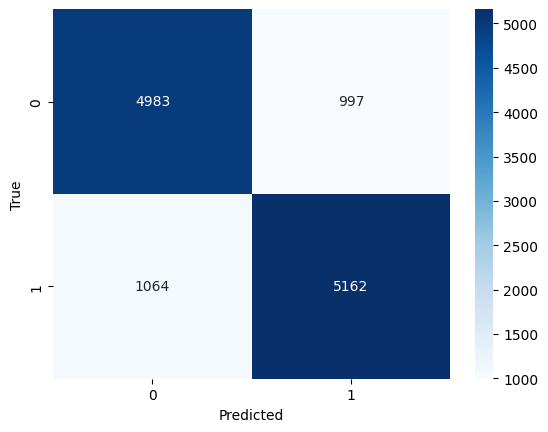

In [126]:
y_predic_ej3 = modelo_hotel_3.predict(x_test_norm)
y_predic_cat_ej3 = np.where(y_predic_ej3>0.5,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej3,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

metricas(ds_validacion.y_pred, ds_validacion.y_real)

In [127]:
hotel_t_norm = stand_scaler.fit_transform(hotel_t)
print(len(hotel_t_norm))

26535


In [140]:
y_predic = modelo_hotel_3.predict(hotel_t_norm)
y_predic_cat = np.where(y_predic>0.5,1,0)
print(len(y_predic_cat))

830/830 [==============================] - 2s 2ms/step
26535


In [141]:
array = []
for i in y_predic_cat:
    array.append(i[0])
print(len(array))

26535


In [142]:
entregable = pd.DataFrame({'id': hotel_orig['id'], 'is_canceled':pd.Series(array).astype(int)})

entregable.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [144]:
entregable.to_csv('redes_modelo_3.csv', index=False)

In [145]:
import pickle

filename1 = "modelo_1"
filename2 = "modelo_2"
filename3 = "modelo_3"

pickle.dump(modelo_hotel_1, open(filename1, "wb"))
pickle.dump(modelo_hotel_2, open(filename2, "wb"))
pickle.dump(modelo_hotel_3, open(filename3, "wb"))